# 0. Load Library

In [1]:
import numpy as np 
import pandas as pd 
import os

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings(action = 'ignore') 
pd.options.display.max_columns = None

In [2]:
for dirname, _, filenames in os.walk('../dacon credit card/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../dacon credit card/dataset\sample_submission.csv
../dacon credit card/dataset\test.csv
../dacon credit card/dataset\train.csv


# 1. Read Dataset

In [3]:
train = pd.read_csv('../dacon credit card/dataset/train.csv')
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [5]:
test = pd.read_csv('../dacon credit card/dataset/test.csv')
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
9996,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
9997,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0
9998,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0


# 2. Simple EDA

## 2-1. Features, Missing Values, Dtype

In [388]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [389]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          10000 non-null  int64  
 1   gender         10000 non-null  object 
 2   car            10000 non-null  object 
 3   reality        10000 non-null  object 
 4   child_num      10000 non-null  int64  
 5   income_total   10000 non-null  float64
 6   income_type    10000 non-null  object 
 7   edu_type       10000 non-null  object 
 8   family_type    10000 non-null  object 
 9   house_type     10000 non-null  object 
 10  DAYS_BIRTH     10000 non-null  int64  
 11  DAYS_EMPLOYED  10000 non-null  int64  
 12  FLAG_MOBIL     10000 non-null  int64  
 13  work_phone     10000 non-null  int64  
 14  phone          10000 non-null  int64  
 15  email          10000 non-null  int64  
 16  occyp_type     6848 non-null   object 
 17  family_size    10000 non-null  float64
 18  begin_m

## 2-2. Summary Statistics

In [390]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [391]:
test.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
count,10000.00000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,31456.50000,0.434700,1.850433e+05,-16020.466400,59776.690400,1.0,0.227600,0.296300,0.085600,2.202700,-26.272400
std,2886.89568,0.729102,1.015398e+05,4197.672887,138121.224504,0.0,0.419304,0.456648,0.279786,0.898272,16.348557
min,26457.00000,0.000000,2.700000e+04,-25152.000000,-15661.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,28956.75000,0.000000,1.215000e+05,-19483.250000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,31456.50000,0.000000,1.575000e+05,-15606.000000,-1577.000000,1.0,0.000000,0.000000,0.000000,2.000000,-25.000000
75%,33956.25000,1.000000,2.250000e+05,-12539.000000,-410.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,36456.00000,5.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,7.000000,0.000000


## 2-3. Count Distinct Observations

In [392]:
train.nunique()

index            26457
gender               2
car                  2
reality              2
child_num            9
income_total       249
income_type          5
edu_type             5
family_type          5
house_type           6
DAYS_BIRTH        6621
DAYS_EMPLOYED     3470
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
occyp_type          18
family_size         10
begin_month         61
credit               3
dtype: int64

In [393]:
test.nunique()

index            10000
gender               2
car                  2
reality              2
child_num            6
income_total       208
income_type          5
edu_type             5
family_type          5
house_type           6
DAYS_BIRTH        4675
DAYS_EMPLOYED     2665
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
occyp_type          18
family_size          7
begin_month         61
dtype: int64

## 2-4. Correlation between Features and Target

In [394]:
train.corr()['credit']

index           -0.007841
child_num        0.004081
income_total     0.008555
DAYS_BIRTH      -0.025187
DAYS_EMPLOYED   -0.003798
FLAG_MOBIL            NaN
work_phone      -0.003134
phone            0.003452
email            0.014812
family_size      0.008227
begin_month     -0.147477
credit           1.000000
Name: credit, dtype: float64

## 2-5. Plot Histogram

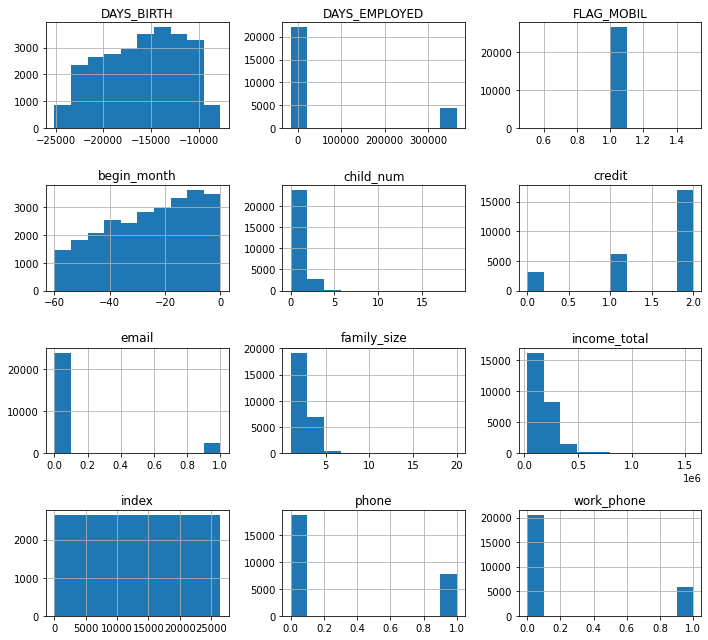

In [395]:
train.hist(figsize=(10, 9))
plt.tight_layout()
plt.show()

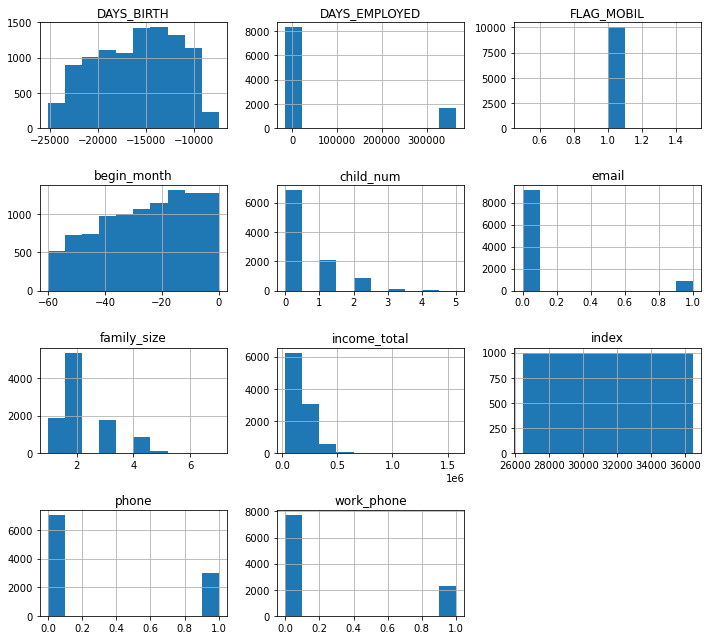

In [396]:
test.hist(figsize=(10, 9))
plt.tight_layout()
plt.show()

# 3. Clean Anomalies

## 3-1. child_num에 대하여 이상치 처리 

In [397]:
# train의 child_num : 0~19 
train['child_num'].value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

In [398]:
# test의 child_num : 0~5
test['child_num'].value_counts()

0    6861
1    2106
2     894
3     113
4      16
5      10
Name: child_num, dtype: int64

In [399]:
train = train[train['child_num'] < 7]
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


## 3-2. DAYS_EMPLOYED 미취업 코드 처리

In [400]:
# train의 DAYS_EMPLOYED의 양수인 데이터의 종류 확인 : 모두 365243으로 동일 (미취업 코드) 
train.loc[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].unique()

array([365243], dtype=int64)

In [401]:
# test의 DAYS_EMPLOYED의 양수인 데이터의 종류 확인 : 모두 365243으로 동일 (미취업 코드) 
test.loc[test['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].unique()

array([365243], dtype=int64)

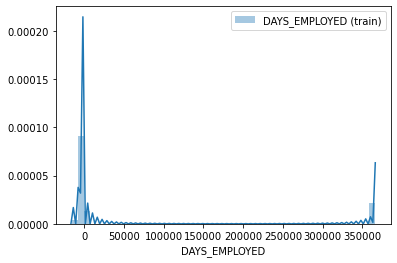

In [402]:
# 이상치 처리 전 DAYS_EMPLOYED 분포 
sns.distplot(train['DAYS_EMPLOYED'], label = 'DAYS_EMPLOYED (train)')
plt.legend() 

In [403]:
# train, test 데이터셋에서의 DAYS_EMPLOYED의 이상치 365243을 1로 변경 
train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 1
test.loc[test['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 1

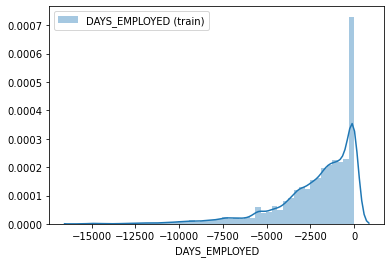

In [404]:
# 이상치 처리 후 DAYS_EMPLOYED 분포 
sns.distplot(train['DAYS_EMPLOYED'], label = 'DAYS_EMPLOYED (train)')
plt.legend()

In [405]:
# DAYS_EMPLOYED 가공해서 EMPLOYED(고용여부) 컬럼 만들기 
train['EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: False if x == 1 else True)
test['EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x: False if x == 1 else True)

# 4. Binning Numeric Features 

## 4-1. income_total 10개 카테고리로 범주화

In [406]:
# binning income_total
_, bins = pd.qcut(train['income_total'], 10, retbins=True)
bins = np.delete(bins, -1)
train['income_bin'] = np.digitize(train['income_total'], bins)
test['income_bin'] = np.digitize(test['income_total'], bins)

## 4-2. DAYS_BIRTH 세대별로 범주화

In [407]:
# binning DAYS_BIRTH 
def binning_age(birth):
    age = abs(birth) / 365
    if 20 <= age < 30 :
        return '20s'
    elif 30 <= age < 40 :
        return '30s'
    elif 40 <= age < 50 :
        return '40s'
    elif 50 <= age < 60 :
        return '50s'
    else:
        return '60s'

train['generation'] = train['DAYS_BIRTH'].apply(binning_age)
test['generation'] = test['DAYS_BIRTH'].apply(binning_age)

# 5. Filling Missing Values

## 5-1. occyp_type 결측치 채우기 : 미취업자의 경우 None으로 처리

In [408]:
# DAYS_EMPLOYED에서 미취업코드 365243에 해당하는 경우는 직업이 없다고 보고 occyp_type 결측치를 None으로 처리 
train.loc[(train['EMPLOYED'] == False) & (train['occyp_type'].isnull()), 'occyp_type'] = 'None'
test.loc[(test['EMPLOYED'] == False) & (test['occyp_type'].isnull()), 'occyp_type'] = 'None'

# income_type은 Student이지만 occyp_type이 결측치인 경우 -> occyp_type 결측치를 None으로 처리 (train에만 1건 존재)
train.loc[(train['income_type'] == 'Student') & (train['occyp_type'].isnull()), 'occyp_type'] = 'None'

## 5-2. occyp_type 결측치 채우기 : 미취업자가 아닌 경우 Nearest Neightbor 대치법 사용

In [409]:
# income_bin과 income_type으로 그루핑하여 같은 집단의 직업 중 최빈값으로 occyp_type 결측치 채우기 
train['occyp_type'] = train.groupby(['income_bin', 'income_type'])['occyp_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'None'))
test['occyp_type'] = test.groupby(['income_bin', 'income_type'])['occyp_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'None'))

# 6. Feature Engineering

## 6-1. 동일인에 대하여 idx_dup 표시

* 해당 데이터셋에는 begin_month, credit을 제외한 모든 컬럼이 같은 중복행들이 존재함. 
* begin_month가 다른 것은 동일인이 여러번 카드 발급을 받은 것으로 유추할 수 있으며 그에 따라 credit이 달라졌음을 추정할 수 있음. 
* 따라서 begin_month, credit 제외 모든 컬럼의 값이 동일한 중복행에 대하여 idx_dup (동일인 표시) 처리를 해줄 필요성이 있음.

In [410]:
col = train.columns.tolist()
del_col = ['index', 'begin_month', 'credit']
for i in del_col:
    col.remove(i)

# idx_dup 추가
idx_dup = train.groupby(col).agg({'index' : 'first'}) # 중복행이 발생할 경우 중복행 중 처음 등장한 행의 index만 남김 
idx_dup.columns = ['idx_dup']
idx_dup = idx_dup.reset_index()

# 중복행들의 idx_dup에 대하여 중복행 중 처음 등장한 행의 index로 통일 
train = pd.merge(train, idx_dup, on = col, how = 'left') 
test = pd.merge(test, idx_dup, on = col, how = 'left') 
test['idx_dup'] = test['idx_dup'].fillna(test['index']) 

## 6-2. 파생변수 추가 

In [411]:
for df in [train, test]:
    df['employed_income'] = df['EMPLOYED'].astype(str) + '_' + df['income_type']

    df['employed_sub_birth'] = df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']
    df['income_div_birth'] = df['income_total'] / df['DAYS_BIRTH']
    df['employed_div_birth'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['income_div_employed'] = df['income_total'] / df['DAYS_EMPLOYED']
    df['employed_multi_birth'] = df['DAYS_EMPLOYED'] * df['DAYS_BIRTH']
    df['income_multi_birth'] = df['income_total'] * df['DAYS_BIRTH']
    df['income_multi_employed'] = df['income_total'] * df['DAYS_EMPLOYED']
    df['birth_div_family'] = df['DAYS_BIRTH'] / df['family_size']
    
    df['property'] = df['car'].replace({'N' : 0, 'Y' : 1}) + df['reality'].replace({'N' : 0, 'Y' : 1}) * 2  + df['phone'] + df['work_phone'] 

# 7. Encoding

In [412]:
# 제거할 컬럼 및 범주형 컬럼 구분
cat_cols = train.columns[train.dtypes == object].tolist()
del_col_list = ['index', 'FLAG_MOBIL', 'income_total']

for i in del_col_list:
    if i in cat_cols:
        cat_cols.remove(i)

In [413]:
# 범주형 변수 Label Encoding
le = LabelEncoder()

for i in cat_cols:
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])

# 8. Modeling

In [414]:
# 모델링을 위해 X, y, X_test 데이터로 나누기
target = 'credit'
X = train.drop(columns = [target] + del_col_list)
y = train[target]
X_test = test.drop(columns = del_col_list)

In [415]:
n_fold = 8
n_class = 3

xgb_pred = np.zeros((X.shape[0], n_class)) # 검증용 
xgb_pred_test = np.zeros((X_test.shape[0], n_class)) # test 

xgb = XGBClassifier(n_jobs = -1, learning_rate = 0.05, n_estimators = 10000, colsample_bytree = 0.2156, max_depth = 10, min_child_weight = 1.265, subsample = 0.8336, use_label_encoder = False)
skf = StratifiedKFold(n_splits = n_fold, random_state = 42, shuffle = True)

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print('=' * 30 + str(fold+1) + '=' * 30)
    X_train, X_valid  = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    xgb.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 30, verbose = 100)
    xgb_pred[valid_idx] = xgb.predict_proba(X_valid)
    xgb_pred_test += xgb.predict_proba(X_test) / n_fold
    
    print(f'{fold+1}번째 CV Log loss Score: {log_loss(y_valid, xgb_pred[valid_idx])}')
    
print('=' * 60)
print(f'평균 CV Log loss Score: {log_loss(y, xgb_pred)}')

==============================1==============================
[03:52:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08018
[100]	validation_0-mlogloss:0.74521
[200]	validation_0-mlogloss:0.70608
[300]	validation_0-mlogloss:0.69160
[400]	validation_0-mlogloss:0.68585
[444]	validation_0-mlogloss:0.68603
1번째 CV Log loss Score: 0.6852959923916397
==============================2==============================
[03:52:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior

In [416]:
# 변수 중요도 확인 
pd.Series(xgb.feature_importances_, index = X.columns).sort_values(ascending = False)

begin_month              0.123086
income_div_employed      0.040208
employed_div_birth       0.039787
idx_dup                  0.039663
employed_sub_birth       0.039535
income_multi_employed    0.039504
birth_div_family         0.038857
income_div_birth         0.038424
income_multi_birth       0.038410
DAYS_EMPLOYED            0.037422
employed_multi_birth     0.037261
DAYS_BIRTH               0.037179
occyp_type               0.029498
property                 0.028393
family_type              0.028296
house_type               0.027645
income_bin               0.027581
employed_income          0.026481
phone                    0.025161
edu_type                 0.024778
email                    0.024754
work_phone               0.024389
generation               0.023711
family_size              0.023602
reality                  0.023491
car                      0.023491
child_num                0.023469
income_type              0.023204
gender                   0.022056
EMPLOYED      